In [1]:
cd ..

/workspaces/language-api


/root/.local/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [45]:
import pandas as pd
import numpy as np 
import ast
from plotnine import *
from itertools import permutations
from sacrebleu.metrics import BLEU
from sacrebleu import sentence_bleu
from src.models.pretrained import load_models

## Read metadata

In [3]:
with open('data/train.metadata') as f:
    metadata = f.readlines()
    
metadata = [ast.literal_eval(line.strip()) for line in metadata]
metadata_df = pd.DataFrame(metadata)

### Metadata sizes

In [4]:
language_pairs_qty = metadata_df.groupby(['src_lang', 'tgt_lang']).size().reset_index().rename(columns={0:'obs'})
language_pairs_qty.sort_values(by='obs')

,src_lang,tgt_lang,obs
10,sv,en,89513
4,en,nb,89786
9,sv,da,93665
7,nb,en,99447
0,da,en,103097
3,en,da,108729
5,en,sv,139502
8,nb,sv,141412
1,da,nb,150826
11,sv,nb,152931


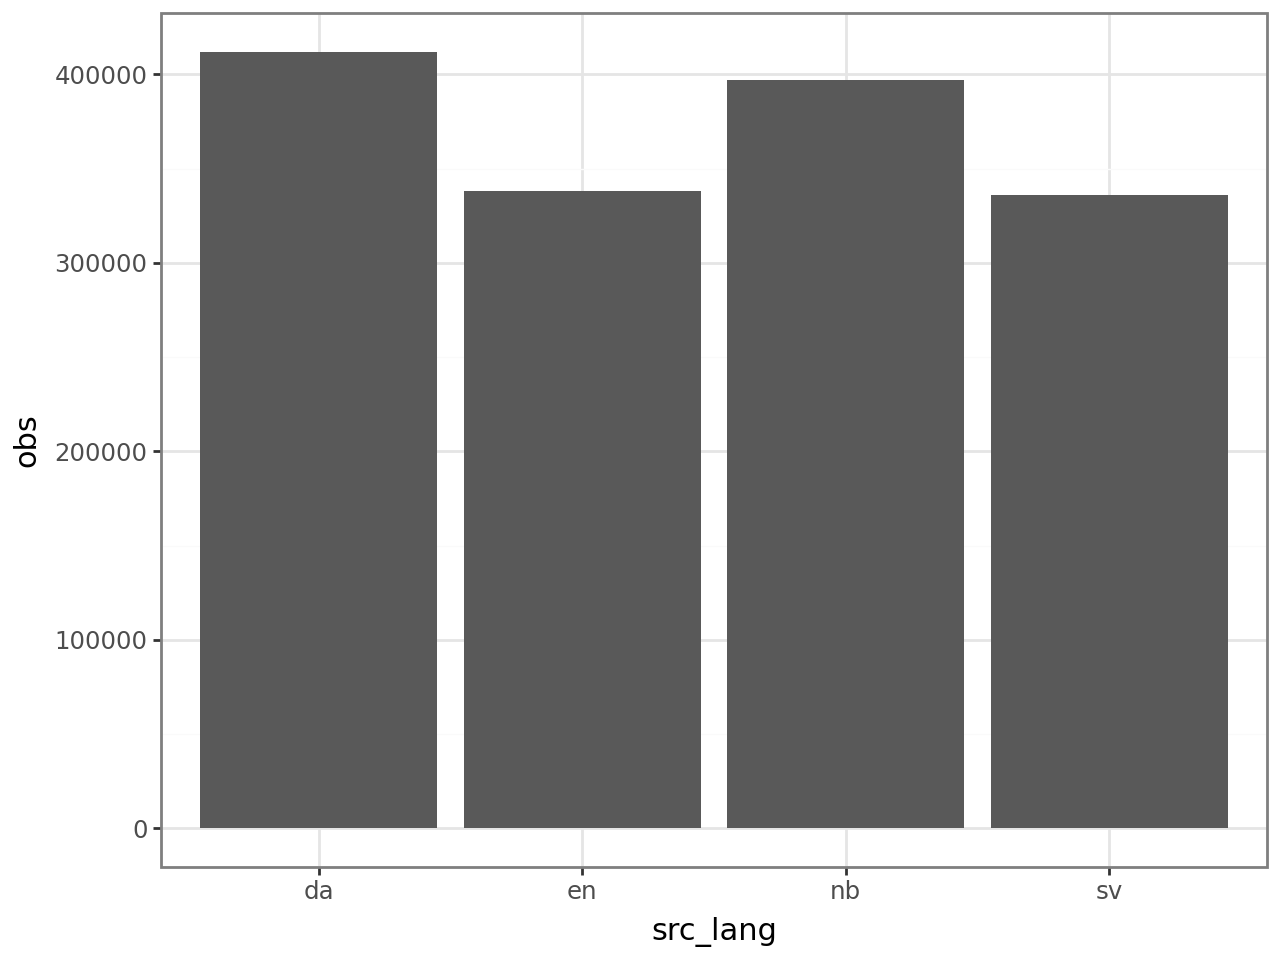

In [5]:
(
    ggplot(language_pairs_qty.groupby('src_lang')['obs'].sum().reset_index(), aes(x='src_lang', y='obs')) +
    geom_bar(stat='identity') +
    theme_bw()
    
)

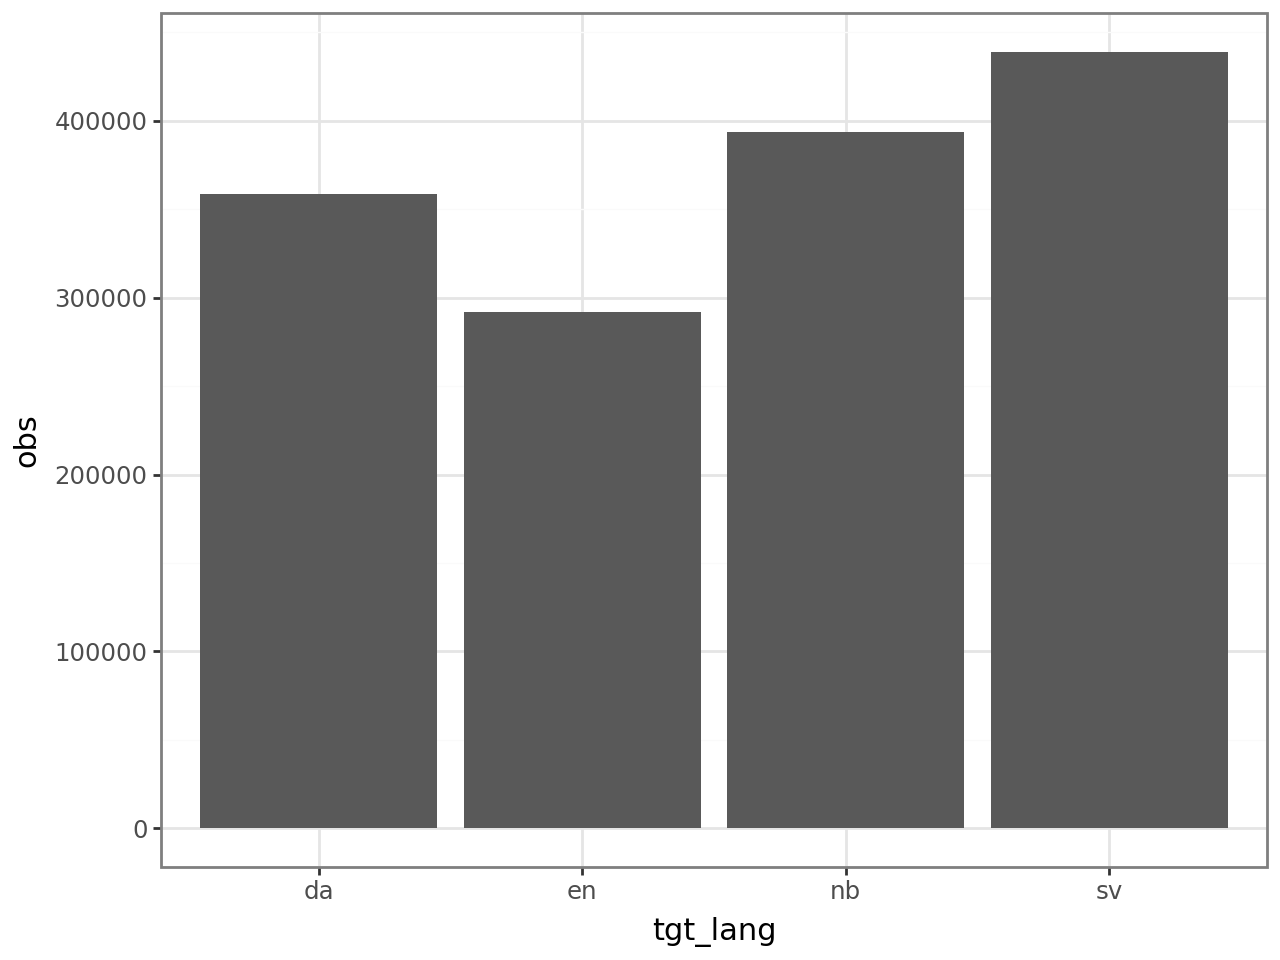

In [6]:
(
    ggplot(language_pairs_qty.groupby('tgt_lang')['obs'].sum().reset_index(), aes(x='tgt_lang', y='obs')) +
    geom_bar(stat='identity') +
    theme_bw()
    
)

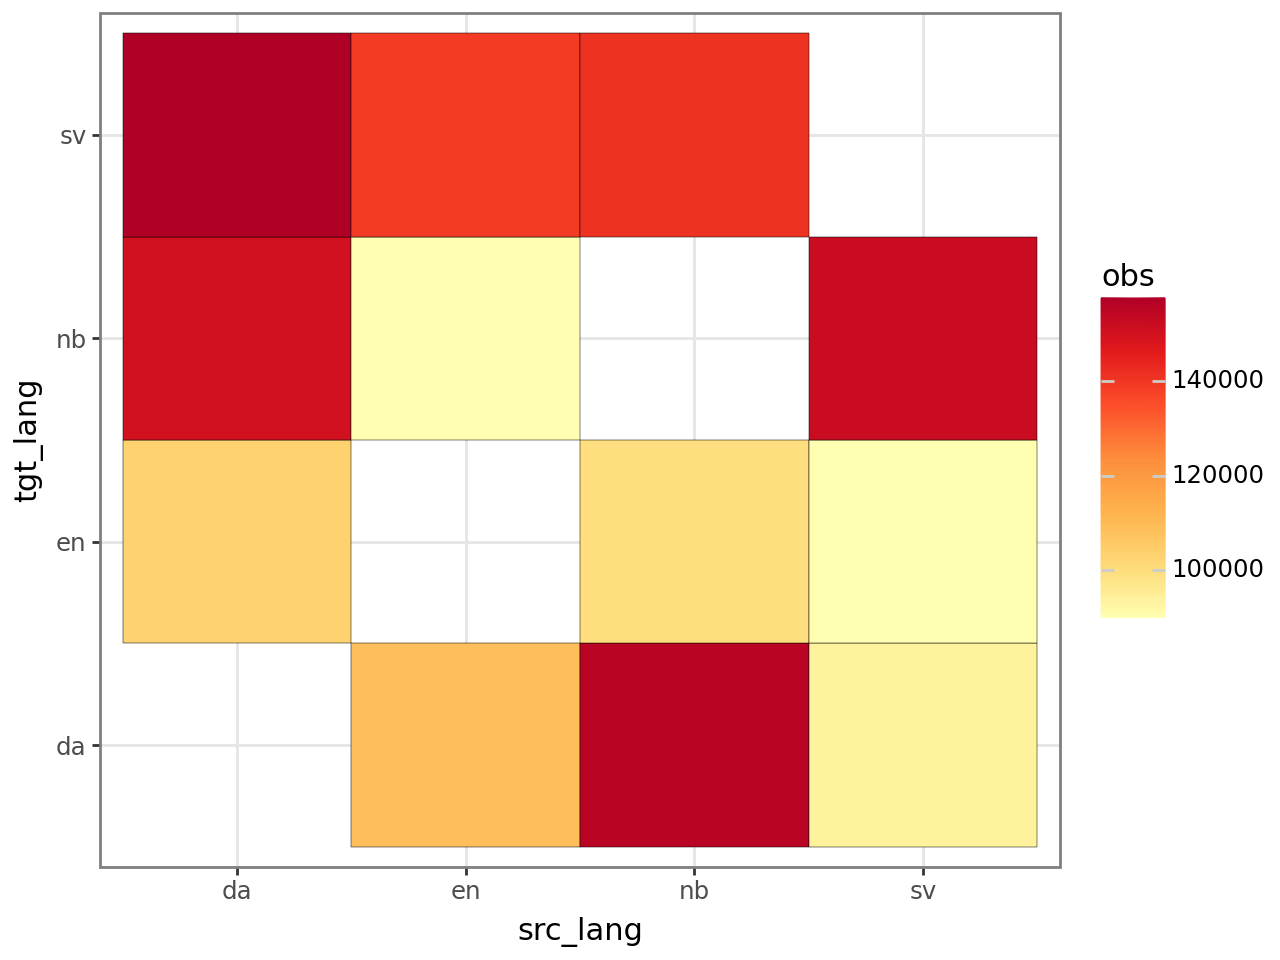

In [7]:
(
    ggplot(language_pairs_qty, aes(x='src_lang', y='tgt_lang', fill='obs')) +
    geom_tile(color='black') +
    scale_fill_distiller(palette='YlOrRd', direction=1) +
    theme_bw()
    
)

## Data distribution

In [8]:
languages = ('en', 'da', 'sv', 'nb')
language_pairs = list(permutations(languages, 2))

sample_indices = pd.DataFrame()
sample_size = 5000
for src, tgt in language_pairs:
    pair_indices = metadata_df.loc[(metadata_df['src_lang'] == src) & (metadata_df['tgt_lang'] == tgt)].sample(n=5000, random_state=0)
    sample_indices = pd.concat([sample_indices, pair_indices])
    


## Distributions (lens, characters, etc)

In [9]:
with open('data/train.src', 'r') as f:
    train_src = f.readlines()

with open('data/train.tgt', 'r') as f:
    train_tgt = f.readlines()

In [10]:
translation_df = metadata_df.copy()
translation_df['src_text'] = train_src
translation_df['tgt_text'] = train_tgt

# Strip trailing spaces
translation_df['src_text'] = translation_df['src_text'].str.strip()
translation_df['tgt_text'] = translation_df['tgt_text'].str.strip()

# Compute character lens
translation_df['src_len'] = translation_df['src_text'].str.len()
translation_df['tgt_len'] = translation_df['tgt_text'].str.len()

In [11]:
(translation_df
 .groupby(['src_lang', 'tgt_lang'])[['src_len', 'tgt_len']]
 .agg(['mean', 'median', 'min', 'max', ('p90', lambda x: np.quantile(x, 0.95))])
)

src_len                            tgt_len             \
                         mean median min  max    p90        mean median min   
src_lang tgt_lang                                                             
da       en         46.551791   16.0   9  512  262.0   46.870248   17.0   8   
         nb         88.108542   73.0  10  500  199.0   86.221328   72.0  10   
         sv         91.301224   74.0  10  500  216.0   90.021201   73.0  10   
en       da        100.061143   57.0   9  512  332.0  100.837863   57.0   9   
         nb         98.370893   86.0  10  508  208.0   98.476266   86.0  10   
         sv         75.518337   54.0  10  499  195.0   75.643424   55.0  10   
nb       da         86.220231   72.0  10  500  194.0   88.109741   74.0  10   
         en         98.281396   86.0  10  510  205.0   98.160256   86.0  10   
         sv         83.811551   70.0  10  495  189.0   84.425643   70.0  10   
sv       da         90.153793   73.0  10  500  213.0   91.418022   74.0  10   
         en         75.121602   54.0  10  496  192.0   74.982126   54.0  10   
         nb         84.515834   70.0  10  500  192.0   83.856242   69.0  10   

                               
                   max    p90  
src_lang tgt_lang              
da       en        512  265.0  
         nb        500  194.0  
         sv        500  214.0  
en       da        512  335.0  
         nb        512  207.0  
         sv        498  194.0  
nb       da        500  199.0  
         en        512  207.0  
         sv        499  191.0  
sv       da        500  216.0  
         en        500  194.0  
         nb        498  189.0

In [12]:
translation_df['src_tokens'] = translation_df['src_text'].str.split().apply(len)
translation_df['tgt_tokens'] = translation_df['tgt_text'].str.split().apply(len)

In [13]:
translation_df.groupby(['src_lang', 'tgt_lang'])[['src_tokens', 'tgt_tokens']].agg(['median', ('p90', lambda x: np.quantile(x, 0.9))])

src_tokens       tgt_tokens      
                      median   p90     median   p90
src_lang tgt_lang                                  
da       en              2.0  36.0        3.0  37.0
         nb             12.0  26.0       12.0  26.0
         sv             12.0  28.0       12.0  27.0
en       da              9.0  43.0        9.0  41.0
         nb             14.0  29.0       14.0  28.0
         sv             10.0  26.0       10.0  24.0
nb       da             12.0  26.0       12.0  26.0
         en             14.0  28.0       14.0  29.0
         sv             12.0  26.0       11.0  25.0
sv       da             12.0  27.0       12.0  28.0
         en              9.0  24.0       10.0  26.0
         nb             11.0  25.0       12.0  26.0

## BLEU scores for samples

In [ ]:
refs = [['The dog bit the guy.', 'It was not unexpected.', 'The man bit him first.']]
hyps = ['The dog bit the man.', "It wasn't surprising.", 'The man had just bitten him.']

In [34]:
bleu = BLEU()

In [ ]:
score = bleu.corpus_score(hyps, refs).score

In [14]:
# Get src and tgt language pairs
cache_path: str = "/cached_models/marianmodels/"
marian_en_da = load_models(language_pair=('en', 'da'), cache_path=cache_path)

/usr/local/lib/python3.12/site-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.


In [16]:
tokenizer, model = marian_en_da.values()

In [50]:
en_da_translations = translation_df.loc[(translation_df['src_lang']=='en') & (translation_df['tgt_lang']=='da')]

row = en_da_translations.sample(1, random_state=64)
row

,src_lang,tgt_lang,src_text,tgt_text,src_len,tgt_len,src_tokens,tgt_tokens
449068,en,da,carbohydrates;,kulhydrater;,14,12,1,1


In [51]:
translated = model.generate(
    **tokenizer(row['src_text'].iloc[0], return_tensors="pt", padding=True)
)
translated_text = [
    tokenizer.decode(t, skip_special_tokens=True) for t in translated
][0]


In [52]:
sentence_bleu(translated_text, [row['tgt_text'].iloc[0]])

BLEU = 36.79 100.0/0.0/0.0/0.0 (BP = 0.368 ratio = 0.500 hyp_len = 1 ref_len = 2)